In [1]:
%load_ext lab_black

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima

In [3]:
data = pd.read_csv("../data/combined.csv").set_index("date")

# Predictive Feature Engineering

Had enough features yet? Me neither. This notebook will contain features that are predictions themselves, with the intent of feeding them to a neural network.

The first few features are going to be versions of linear projections, essentially guessing that the price change from the last week will be the price change for the next week.

In [4]:
gas_price = data["gas_price"]

# one week change
lin1 = gas_price + (gas_price - gas_price.shift(1))

# ten week change
lin10 = gas_price + (gas_price - gas_price.shift(10)) / 10

Additionally, an OLS regression will be fit on a windowing opperation, and it will be used to extrapolate to the next week.

In [5]:
def ols(y):
    # get number of points to fit
    window = len(y)
    # get dummy x values
    x = np.linspace(0, window, window)
    # calculate standard deviations
    stdx = np.std(x)
    # if std x is zero, std y is also zero. cast t 1 for safe division
    stdx = stdx if stdx else 1
    stdy = np.std(y)

    # get pearson coefficient
    r = np.corrcoef(y)

    # calculate ols coefficients
    beta1 = r * stdy / stdx
    beta0 = np.mean(y) - beta1 * np.mean(x)

    # guess next point
    return beta0 + beta1 * (window + 1)


ols10 = gas_price.rolling(window=10, min_periods=2).apply(ols)

As the final feature, I will fit an ARIMA model to a portion of the data, and then forecast the test set.

In [6]:
arima_df = data.copy()
# shift the data up one
arima_df["gas_price"] = arima_df["gas_price"].shift(-1).ffill()

train = arima_df.loc[:"2019-01-01"].copy()
test = arima_df.loc["2019-01-01":].copy()

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    arima = auto_arima(
        train["gas_price"],
        X=train[[col for col in data.columns if col != "gas_price"]],
        start_p=0,
        start_q=0,
        max_p=30,
        max_q=30,
        d=0,
        trace=True,
    )

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1994.504, Time=2.48 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-4244.427, Time=2.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1556.205, Time=2.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6341.873, Time=2.42 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-4247.943, Time=3.22 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-4246.446, Time=3.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4247.217, Time=3.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4248.213, Time=3.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4246.786, Time=3.46 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2994.528, Time=3.46 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-4234.236, Time=3.94 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4250.223, Time=2.85 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1558.132, Time=3.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4246.445, Time=2.43 sec
 ARIMA(2,0,1)(0,0,0)

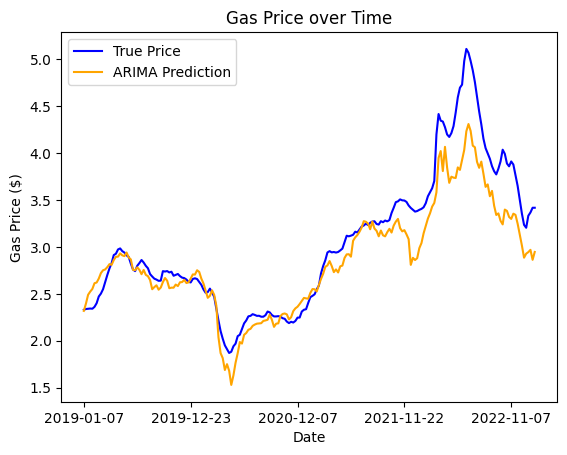

In [7]:
# view the arima forecast on the test data
arima_pred = arima.predict(
    n_periods=len(test),
    X=test[[col for col in data.columns if col != "gas_price"]],
)

test["arima"] = arima_pred.values
ticks = test.index[::50]
plt.plot(test["gas_price"], color="blue", label="True Price")
plt.plot(test["arima"], color="orange", label="ARIMA Prediction")
plt.xlabel("Date")
plt.ylabel("Gas Price ($)")
plt.title("Gas Price over Time")
plt.xticks(ticks)
plt.legend()

In [8]:
# create the arima prediction feature for all data points
arima_pred = arima.predict(
    n_periods=len(arima_df),
    X=arima_df[[col for col in data.columns if col != "gas_price"]],
)

In [9]:
# merge the data
predictive = {
    "short_linear_projection": lin1,
    "long_linear_projection": lin10,
    "ols": ols10,
    "arima": arima_pred.values,
}

predictive = pd.DataFrame(predictive).bfill()

In [10]:
predictive.to_csv("../data/predictive_features.csv")